# Import libraries

In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 13.9/13.9 MB 8.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\katap\.virtualenvs\workspace\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from langdetect import detect
import datetime
from nltk import word_tokenize
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import figure
import contractions
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models.fasttext import FastText
import fasttext
from sklearn.decomposition import PCA
import dask.dataframe as dd
import joblib
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import spreg

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\katap\.virtualenvs\workspace\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


# Getting data

For this project I used a dataset in order to get the tweets I was interested in. For more details see:
https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329

In [3]:
df = pd.read_csv('data/tweets.csv', delimiter=';')

C:\Users\katap\AppData\Local\Temp\ipykernel_20732\2122514096.py:1: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/tweets.csv', delimiter=';')


In [4]:
len(df)

20165013

In [5]:
df.head()

id           user             fullname  url  \
0  1132977055300300800   KamdemAbdiel        Abdiel kamdem  NaN   
1  1132977073402736640      bitcointe            Bitcointe  NaN   
2  1132977023893139456      3eyedbran  Bran - 3 Eyed Raven  NaN   
3  1132977089089556481  DetroitCrypto          J. Scardina  NaN   
4  1132977092340191232   mmursaleen72   Muhammad Mursaleen  NaN   

                timestamp  replies  likes  retweets  \
0  2019-05-27 11:49:14+00      0.0    0.0       0.0   
1  2019-05-27 11:49:18+00      0.0    0.0       0.0   
2  2019-05-27 11:49:06+00      0.0    2.0       1.0   
3  2019-05-27 11:49:22+00      0.0    0.0       0.0   
4  2019-05-27 11:49:23+00      0.0    0.0       0.0   

                                                text  
0  È appena uscito un nuovo video! LES CRYPTOMONN...  
1  Cardano: Digitize Currencies; EOS https://t.co...  
2  Another Test tweet that wasn't caught in the s...  
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...  
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...

In [6]:
# drop unused columns
df = df.drop(['id', 'fullname', 'url', 'user'], axis=1)
df.reset_index(drop=True, inplace=True)
df.head()

timestamp  replies  likes  retweets  \
0  2019-05-27 11:49:14+00      0.0    0.0       0.0   
1  2019-05-27 11:49:18+00      0.0    0.0       0.0   
2  2019-05-27 11:49:06+00      0.0    2.0       1.0   
3  2019-05-27 11:49:22+00      0.0    0.0       0.0   
4  2019-05-27 11:49:23+00      0.0    0.0       0.0   

                                                text  
0  È appena uscito un nuovo video! LES CRYPTOMONN...  
1  Cardano: Digitize Currencies; EOS https://t.co...  
2  Another Test tweet that wasn't caught in the s...  
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...  
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...

In [7]:
# Save raw tweets
pickle_out = open('data/tweets_raw.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Transform timestamp column in a date format

In [8]:
# Load raw tweets
pickle_in = open('data/tweets_raw.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [63]:
# Convert timestamp to date
def dt(x):
    t = pd.Timestamp(x)
    return pd.Timestamp.date(t)

In [10]:
df['timestamp'] = df['timestamp'].progress_apply(dt)

100%|██████████| 20165013/20165013 [00:54<00:00, 372758.32it/s]


# Filter tweets from December 1 2017 to February 1 2018

In [11]:
starDate = datetime.date(2018, 1, 1)
endDate = datetime.date(2018, 12, 31)

In [12]:
# Set start date of tweets
df = df[df['timestamp'] >= starDate]

In [13]:
# Set end date of tweets
df = df[df['timestamp'] <= endDate]

In [14]:
len(df["text"])

2164498

In [15]:
min(df['timestamp'])

datetime.date(2018, 1, 1)

In [16]:
max(df['timestamp'])

datetime.date(2018, 12, 31)

In [17]:
# Save tweets from December 1 2017 to February 1 2018
pickle_out = open('data/tweets_jan2018_dec2018.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Detect the language

In [18]:
# Load tweets from December 1 2017 to February 1 2018
pickle_in = open('data/tweets_jan2018_dec2018.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [19]:
path_to_pretrained_model = 'data/fasttext_detect_lang_pretrain.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)

In [20]:
def detect_lang(text):
    return fmodel.predict(text)

In [21]:
df['text'] = df['text'].progress_apply(lambda x: str(x))

100%|██████████| 2164498/2164498 [00:01<00:00, 2007664.53it/s]


In [22]:
df['text'] = df['text'].progress_apply(lambda x: x.replace('\n', ' '))

100%|██████████| 2164498/2164498 [00:01<00:00, 1822746.50it/s]


In [23]:
df['language'] = df['text'].progress_apply(lambda x: detect_lang(x))

100%|██████████| 2164498/2164498 [00:35<00:00, 61254.07it/s] 


In [24]:
df['language'] = df['language'].progress_apply(lambda x: x[0][0].split('__')[2])

100%|██████████| 2164498/2164498 [00:01<00:00, 1649152.12it/s]


In [25]:
df['language'] = df['language'].progress_apply(lambda x: str(x))

100%|██████████| 2164498/2164498 [00:01<00:00, 2007664.53it/s]


In [26]:
df = df[df['language'] == 'en']

In [27]:
len(df["text"])

1248325

There are 1248325 tweets in english available for search terms #bitcoin or #BTC from January 1 2018 to December 31 2018.

In [28]:
# Save english tweets
pickle_out = open('data/tweets_en.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Create the Corpus

In [29]:
# Load raw tweets
pickle_in = open('data/tweets_en.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [30]:
# Clean the text
def clean_text(raw_string):
    # remove emoji
    # emoji_pattern = re.compile("["
    #                            u"\U0001F600-\U0001F64F"  # emoticons
    #                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #                            u"\U00002702-\U000027B0"
    #                            u"\U000024C2-\U0001F251"
    #                            "]+", flags=re.UNICODE)
    # cleaned_string = emoji_pattern.sub(r'', raw_string)

    #cleaned_string = raw_string
    #remove handles
    cleaned_string = re.sub(r'@(\S+)', '', raw_string)

    cleaned_string = re.sub(r'\$(\S+)', '', cleaned_string)
    # remove urls
    cleaned_string = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', cleaned_string)
    # remove special characters
    # cleaned_string = re.sub("[^A-Za-zșȘȚțÎîÂâĂă.,:!?'\- ]", " ", cleaned_string, re.I)
    cleaned_string = re.sub(r'[^A-Za-z.,:!?\'’;\-#\" ]', " ", cleaned_string, re.I)
    # remove multiple spaces
    cleaned_string = re.sub(' +', ' ', cleaned_string)
    return cleaned_string

In [31]:
df['text']= df['text'].astype(str)

In [32]:
df.head(25)

timestamp  replies    likes  retweets  \
101    2018-09-11      0.0      3.0       2.0   
416    2018-12-29      9.0     61.0      16.0   
860    2018-04-17      1.0      7.0       1.0   
1599   2018-02-08     23.0    135.0      51.0   
4222   2018-06-09     39.0    324.0     160.0   
4633   2018-05-05     32.0    197.0     183.0   
5912   2018-12-29    180.0   2059.0     648.0   
9926   2018-02-16     90.0   1598.0     502.0   
13079  2018-08-07     85.0     95.0      87.0   
13306  2018-12-29      2.0    100.0     132.0   
13574  2018-12-23     18.0    146.0      29.0   
14565  2018-01-08      2.0     42.0       7.0   
14590  2018-12-27    971.0    995.0     956.0   
15120  2018-09-02      5.0     72.0      32.0   
16984  2018-08-25      1.0     30.0      16.0   
17636  2018-07-15      0.0      5.0       3.0   
18739  2018-03-27      0.0     74.0      78.0   
20497  2018-08-20      5.0     63.0      49.0   
29612  2018-01-31      1.0     14.0       5.0   
29613  2018-01-31      2.0      6.0       4.0   
32148  2018-10-08    502.0  11401.0    3370.0   
32285  2018-07-05      1.0     13.0       6.0   
38698  2018-04-29     25.0    332.0      78.0   
41867  2018-12-01      1.0     42.0       6.0   
41966  2018-07-02      0.0      3.0       5.0   

                                                    text language  
101    I didnt tether at $7300 #iamspartacus $btc $et...       en  
416    The first lab made diamond happened in 1955 &a...       en  
860    Great talk and discussions about Bitcoin vs. E...       en  
1599   When things are down, remember it's never as b...       en  
4222   Wow! We reached 25K followers just within 4 we...       en  
4633   I’m back!!! Today's #giveaway is 0.35 #BTC (va...       en  
5912   Is #History repeating? 🤔   #Bitcoin / #Gold ht...       en  
9926   Professional Certifications that will help jum...       en  
13079  I will choose 10 Random Followers to Win 1000 ...       en  
13306  Remiit, a blockchain-powered remittance platfo...       en  
13574  The bear market came and it broke us. Not in t...       en  
14565  #bitcoin #aksaraytravesti #bakırköytravesti #ç...       en  
14590  #electrumdark biggest #Airdrop is live,  5000 ...       en  
15120  Paying with My #Bitcoin at a brand new #Crypto...       en  
16984  True story!! Sad and unfortunate that even gre...       en  
17636  @jeremyrwelch @TheFlamcake @balajis @udiWerthe...       en  
18739  Currently, the transference of ownership or pu...       en  
20497  #Blockchain File Certification.  link: https:/...       en  
29612  #BusinessCards #Online  ⭐️https://t.co/SEztImG...       en  
29613  #PILLOWS #Online  ⭐️https://t.co/Z1y7l4Ozcc  #...       en  
32148                                            Bitcoin       en  
32285  #FIAT money is backed by imposition. #Bitcoin ...       en  
38698         #bitcoin #btc $btc https://t.co/5Zn0BDcTYm       en  
41867              $BTC | Weekly https://t.co/2idi3WfLog       en  
41966  Soliciting cyber #hacking is a #crime. #BobThu...       en

In [33]:
tweet_corpus = pd.DataFrame(df)
tweet_corpus['text'] = tweet_corpus['text'].progress_apply(lambda text: clean_text(text))

100%|██████████| 1248325/1248325 [00:17<00:00, 70948.63it/s]


In [34]:
tweet_corpus.head(25)

timestamp  replies    likes  retweets  \
101    2018-09-11      0.0      3.0       2.0   
416    2018-12-29      9.0     61.0      16.0   
860    2018-04-17      1.0      7.0       1.0   
1599   2018-02-08     23.0    135.0      51.0   
4222   2018-06-09     39.0    324.0     160.0   
4633   2018-05-05     32.0    197.0     183.0   
5912   2018-12-29    180.0   2059.0     648.0   
9926   2018-02-16     90.0   1598.0     502.0   
13079  2018-08-07     85.0     95.0      87.0   
13306  2018-12-29      2.0    100.0     132.0   
13574  2018-12-23     18.0    146.0      29.0   
14565  2018-01-08      2.0     42.0       7.0   
14590  2018-12-27    971.0    995.0     956.0   
15120  2018-09-02      5.0     72.0      32.0   
16984  2018-08-25      1.0     30.0      16.0   
17636  2018-07-15      0.0      5.0       3.0   
18739  2018-03-27      0.0     74.0      78.0   
20497  2018-08-20      5.0     63.0      49.0   
29612  2018-01-31      1.0     14.0       5.0   
29613  2018-01-31      2.0      6.0       4.0   
32148  2018-10-08    502.0  11401.0    3370.0   
32285  2018-07-05      1.0     13.0       6.0   
38698  2018-04-29     25.0    332.0      78.0   
41867  2018-12-01      1.0     42.0       6.0   
41966  2018-07-02      0.0      3.0       5.0   

                                                    text language  
101                     I didnt tether at #iamspartacus        en  
416    The first lab made diamond happened in 55 &amp...       en  
860    Great talk and discussions about Bitcoin vs. E...       en  
1599   When things are down, remember it's never as b...       en  
4222   Wow! We reached K followers just within 4 week...       en  
4633   I’m back!!! Today's #giveaway is . 5 #BTC (val...       en  
5912              Is #History repeating? #Bitcoin #Gold        en  
9926   Professional Certifications that will help jum...       en  
13079  I will choose Random Followers to Win 1000 #AD...       en  
13306  Remiit, a blockchain-powered remittance platfo...       en  
13574  The bear market came and it broke us. Not in t...       en  
14565  #bitcoin #aksaraytravesti #bak rk ytravesti #ç...       en  
14590  #electrumdark biggest #Airdrop is live, 00 luc...       en  
15120  Paying with My #Bitcoin at a brand new #Crypto...       en  
16984  True story!! Sad and unfortunate that even gre...       en  
17636   Who’s making more right now in the market - a...       en  
18739  Currently, the transference of ownership or pu...       en  
20497  #Blockchain File Certification. link: #crypto ...       en  
29612  #BusinessCards #Online #B2B #bitcoin #Smallbiz...       en  
29613  #PILLOWS #Online #B2B #bitcoin #Smallbiz #Chur...       en  
32148                                            Bitcoin       en  
32285  #FIAT money is backed by imposition. #Bitcoin ...       en  
38698                                     #bitcoin #btc        en  
41867                                            Weekly        en  
41966  Soliciting cyber #hacking is a #crime. #BobThu...       en

In [35]:
# Save clean tweets
pickle_out = open('data/tweets_clean.pkl','wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

# Compute number of words in tweet

In [36]:
# Load english tweets
pickle_in = open('data/tweets_clean.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [37]:
tweet_corpus['text_len'] = tweet_corpus['text'].progress_apply(lambda x: len(word_tokenize(x)))

100%|██████████| 1248325/1248325 [01:44<00:00, 11930.14it/s]


In [38]:
tweet_corpus.sample(5)

timestamp  replies  likes  retweets  \
6343685  2018-06-05      0.0    0.0       0.0   
4912064  2018-08-03      0.0    0.0       0.0   
4961763  2018-08-03      0.0    1.0       0.0   
4850236  2018-08-03      0.0    0.0       0.0   
6625602  2018-04-05      0.0    0.0       0.0   

                                                      text language  text_len  
6343685  There’s usually a cooling period after anythin...       en        59  
4912064                                                          en         0  
4961763                                                          en         0  
4850236  Square achieves over million Bitcoin revenue i...       en        13  
6625602   PM EST price of today is #dailycoinprices #bt...       en        12

In [39]:
tweet_corpus.to_csv('data/tweet_corpus.csv', index=False)

In [40]:
tweet_corpus = pd.read_csv('data/tweet_corpus.csv')
tweet_corpus.head()

timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  
0                   I didnt tether at #iamspartacus        en         6  
1  The first lab made diamond happened in 55 &amp...       en        59  
2  Great talk and discussions about Bitcoin vs. E...       en        15  
3  When things are down, remember it's never as b...       en        62  
4  Wow! We reached K followers just within 4 week...       en        48

# Preprocess data

In [41]:
# Check data types in corpus
tweet_corpus.dtypes

timestamp     object
replies      float64
likes        float64
retweets     float64
text          object
language      object
text_len       int64
dtype: object

In [42]:
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text          True
language     False
text_len     False
dtype: bool

In [43]:
tweet_corpus = tweet_corpus.dropna()

In [44]:
# Transform data types to strings for easy management
tweet_corpus['text'] = tweet_corpus['text'].astype(str)

In [45]:
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text         False
language     False
text_len     False
dtype: bool

In [46]:
replies_number = tweet_corpus['replies'].value_counts().sort_index()
replies_number = replies_number.drop(index = replies_number.index[0], axis = 0)

In [47]:
print(type(replies_number))

<class 'pandas.core.series.Series'>


In [48]:
replies_number = replies_number.to_frame()

In [49]:
# replies_number.set_index('replies', inplace=True)

In [50]:
replies_number['freq'] = replies_number.index

In [51]:
replies_number

replies     freq
1.0        69097      1.0
2.0        16958      2.0
3.0         6944      3.0
4.0         3436      4.0
5.0         2032      5.0
...          ...      ...
4953.0         1   4953.0
5158.0         1   5158.0
5215.0         1   5215.0
7349.0         1   7349.0
22759.0        1  22759.0

[515 rows x 2 columns]

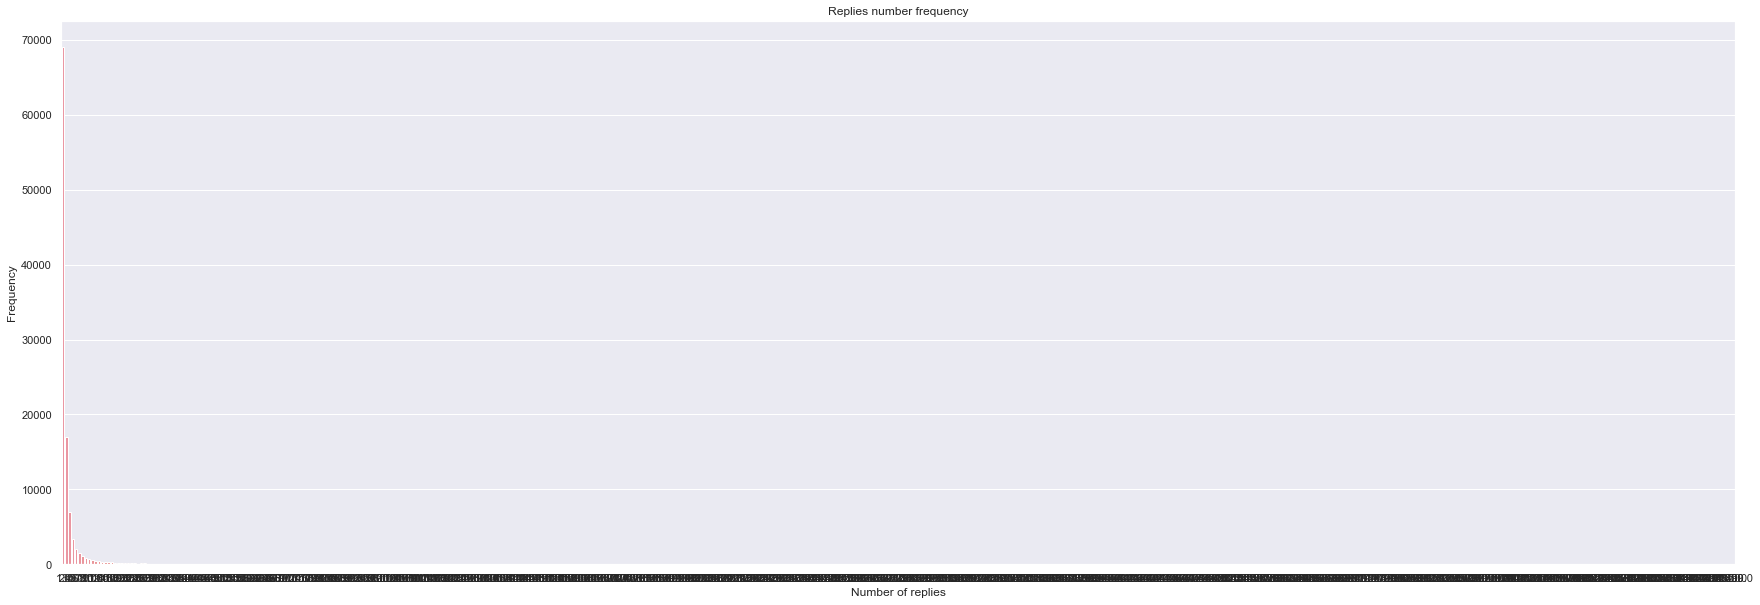

In [54]:
# sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(30,10)})
# ax = sns.countplot(x='freq', data=replies_number)
ax = sns.barplot(x='freq', y='replies', data=replies_number)
# for p in ax.patches:
#     ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
ax.set_title('Replies number frequency')
ax.set_xlabel('Number of replies')
ax.set_ylabel('Frequency')
plt.savefig('graphs_new/Replies number frequency sns.png', bbox_inches='tight')

In [55]:
# Plot the frequency of number of replies
figure(num=None, figsize=(20,18), dpi=512, facecolor='w', edgecolor='r')
fig = tweet_corpus['replies'].value_counts().sort_index().plot(kind='bar')
# fig = replies_number.plot(kind='bar')
fig.set_title('Replies number frequency')
fig.set_xlabel('Number of replies')
fig.set_ylabel('Frequency')
plt.savefig('graphs_new/Replies number frequency.png', bbox_inches='tight')

In [56]:
# Plot the frequency of number of words in tweets
figure(num=None, figsize=(20,18), dpi=512, facecolor='w', edgecolor='r')
fig = tweet_corpus['text_len'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of number of words in tweets')
fig.set_xlabel('Number of words in tweets')
fig.set_ylabel('Frequency')
plt.savefig('graphs_new/Frequency of number of words in tweets.png', bbox_inches='tight')

In [58]:
def preprocess(document):
    document = str(document)
    # Contractions
    #document = contractions.fix(document)
    # Lowercasing
    #document = document.lower()
    # Remove any whitespaces
    #document = re.sub(r'[^\w\s]', ' ', document)
    #document = re.sub(r'[^a-z ]', '', document)
    # Word Tokenize
    document = word_tokenize(document)
    # Stopwords
    stop_words = stopwords.words('english')
    document = [word for word in document if word not in stop_words]
    # Lemmatizer
    document = ' '.join(document)
    document = [word.lemma_ for word in nlp(document)]
    # Change the output to a sentence
    document = ' '.join(document)

    return document

In [59]:
# tweet_corpus['text'][48679]

In [60]:
tweet_corpus['text_prep'] = tweet_corpus['text'].progress_apply(lambda x: preprocess(x))

100%|██████████| 923591/923591 [36:07<00:00, 426.05it/s] 


In [61]:
#tweet_corpus['text_prep'] = [preprocess(document) for document in tweet_corpus['text'].to_list()]
tweet_corpus.head()

timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   

                                           text_prep  
0                     I do not tether # iamspartacus  
1  the first lab make diamond happen 55 & amp ; f...

In [62]:
# Save corpus in csv
tweet_corpus.to_csv('data/tweet_corpus_clean.csv', index=False)

# Bag of words top 5000

In [2]:
# Read corpus from csv
tweet_corpus = pd.read_csv('data/tweet_corpus_clean.csv')

In [63]:
# Check for missing values
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text         False
language     False
text_len     False
text_prep    False
dtype: bool

In [64]:
# Remove missing values
tweet_corpus = tweet_corpus.dropna()

In [65]:
corpus_text = tweet_corpus['text_prep']

In [66]:
# Create dtm (document term matrix) for most frequent 5000 words
vec_text = CountVectorizer(max_features=4000)
counts_per_text = vec_text.fit_transform(corpus_text)
counts_per_text

<923591x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 10883289 stored elements in Compressed Sparse Row format>

In [67]:
text_words = vec_text.get_feature_names_out()
text_words[np.random.randint(0, len(text_words) - 1)]

'786'

In [68]:
# dtm_text_dd = dd.from_array(counts_per_text.toarray(), columns = text_words)
# dtm_text_dd.head()

In [ ]:
dtm_text = pd.DataFrame(counts_per_text.toarray(), columns = text_words)
dtm_text.head()

In [84]:
len(dtm_text)

923591

In [79]:
# Create new column that contains only the words in DTM (from the 5000 words)
tweet_corpus['text_prep_lim'] = tweet_corpus['text_prep'].progress_apply(word_tokenize)
tweet_corpus.head()

100%|██████████| 923591/923591 [05:43<00:00, 2686.71it/s] 


timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  
0              [I, do, not, tether, #, iamspartacus]                  3  
1  [the, first, lab, make, diamond, happen, 55, &...                 26  
2  [great, talk, discussion, Bitcoin, vs., Euro, ...                  4  
3  [when, thing, ,, remember, be, never, bad, cho...                 17  
4  [wow, !, we, reach, K, follower, within, 4, we...                 21

In [81]:
# Check in the 5000 words and see if text_prep words are in there
tweet_corpus['text_prep_lim'] = tweet_corpus['text_prep_lim'].progress_apply(lambda x:[word for word in x if word in text_words])
tweet_corpus.head()

100%|██████████| 923591/923591 [17:03<00:00, 902.28it/s]  


timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  
0                                  [do, not, tether]                  3  
1  [the, first, make, diamond, happen, 55, amp, m...                 26  
2                   [great, talk, discussion, thank]                  4  
3  [when, thing, remember, be, never, bad, crash,...                 17  
4  [wow, we, reach, follower, within, week, we, h...                 21

100%|██████████| 923591/923591 [05:45<00:00, 2675.57it/s]


timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  
0                                  [do, not, tether]                  3  
1  [the, first, make, diamond, happen, 55, amp, m...                 26  
2                   [great, talk, discussion, thank]                  4  
3  [when, thing, remember, be, never, bad, crash,...                 17  
4  [wow, we, reach, follower, within, week, we, h...                 21

In [83]:
# Get no of words
tweet_corpus['word_len_text_lim'] = tweet_corpus['text_prep_lim'].progress_apply(len)
tweet_corpus.head()

100%|██████████| 923591/923591 [00:00<00:00, 1688867.58it/s]


timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  
0                                  [do, not, tether]                  3  
1  [the, first, make, diamond, happen, 55, amp, m...                 26  
2                   [great, talk, discussion, thank]                  4  
3  [when, thing, remember, be, never, bad, crash,...                 17  
4  [wow, we, reach, follower, within, week, we, h...                 21

In [ ]:
# Save the dtms
# dtm_text.to_csv("data/dtm_text_bow.csv", index=False)
# tweet_corpus.to_csv('data/tweet_corpus_cleaned.csv', index=False)

In [ ]:
# Save clean tweets
# pickle_out = open('data/dtm_text_bow.pkl','wb')
# pickle.dump(dtm_text, pickle_out)
# pickle_out.close()

In [85]:
# Save clean tweets
pickle_out = open('data/tweet_corpus_cleaned.pkl','wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

In [86]:
import joblib

In [87]:
filename = 'dtm_text_bow.sav'
joblib.dump(dtm_text, filename)

['dtm_text_bow.sav']

# Wordcloud

In [88]:
# Load english tweets
# pickle_in = open('data/dtm_text_bow.pkl','rb')
# dtm_text = pickle.load(pickle_in)
# pickle_in.close()

In [2]:
filename = 'dtm_text_bow.sav'
dtm_text = joblib.load(filename)

In [3]:
# Load english tweets
pickle_in = open('data/tweet_corpus_cleaned.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [4]:
# Read the dtms
#dtm_text = pd.read_csv('data/dtm_text_bow.csv', engine='python')

In [5]:
# tweet_corpus = pd.read_csv('data/tweet_corpus_cleaned.csv')

In [6]:
dtm_text.head()

00  000  0000  00000  000000  00000000  00000001  00000002  00000003  \
0   0    0     0      0       0         0         0         0         0   
1   0    0     0      0       0         0         0         0         0   
2   0    0     0      0       0         0         0         0         0   
3   0    0     0      0       0         0         0         0         0   
4   0    0     0      0       0         0         0         0         0   

   00000019  ...  zec  zen  zencash  zeos  zero  zerocarbonproject  zil  zone  \
0         0  ...    0    0        0     0     0                  0    0     0   
1         0  ...    0    0        0     0     0                  0    0     0   
2         0  ...    0    0        0     0     0                  0    0     0   
3         0  ...    0    0        0     0     0                  0    0     0   
4         0  ...    0    0        0     0     0                  0    0     0   

   zrx  ás  
0    0   0  
1    0   0  
2    0   0  
3    0   0  
4    0   0  

[5 rows x 4000 columns]

In [7]:
wordcloud_freq_text = dtm_text.sum(axis=0)
wordcloud_freq_text

00                   267812
000                   22645
0000                    673
00000                  5007
000000                  904
                      ...  
zerocarbonproject       739
zil                     341
zone                   1380
zrx                     454
ás                     3120
Length: 4000, dtype: int64

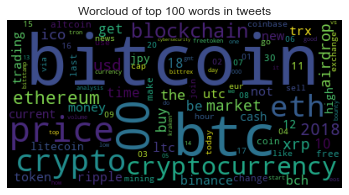

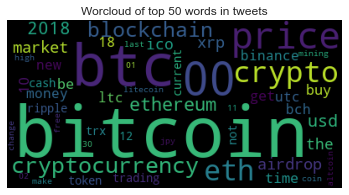

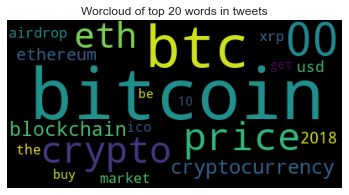

In [12]:
for i in [100,50,20]:
    wordcloud_text = WordCloud(max_words=i, background_color = 'black', colormap = None)
    wordcloud_text.generate_from_frequencies(wordcloud_freq_text)
    plt.imshow(wordcloud_text)
    plt.axis('off')
    plt.title(f"Worcloud of top {i} words in tweets")
    # plt.savefig('graphs_new/Wordcloud ' + i + '.png', bbox_inches='tight')
    plt.show()

# Word Frequency

In [13]:
word_freq_text = pd.DataFrame(wordcloud_freq_text).reset_index()
word_freq_text.columns = ['Word', 'Count']
word_freq_text.head()

Word   Count
0      00  267812
1     000   22645
2    0000     673
3   00000    5007
4  000000     904

In [14]:
# Let's check the most frequent words
word_freq_text = word_freq_text.sort_values(by='Count', ascending=False)

In [15]:
# Let's create a barchart of frequencies
top20_text = word_freq_text[0:19].copy()
top20_text

Word   Count
1159         bitcoin  750886
1276             btc  478789
0                 00  267812
3026           price  183754
1560          crypto  165847
1854             eth  153041
1568  cryptocurrency  139789
1212      blockchain  122633
1856        ethereum   95091
214             2018   83751
3782             usd   75884
946          airdrop   68272
2598          market   65996
3959             xrp   64367
3606             the   60178
2252             ico   57055
1316             buy   51952
1117              be   51222
82                10   49789

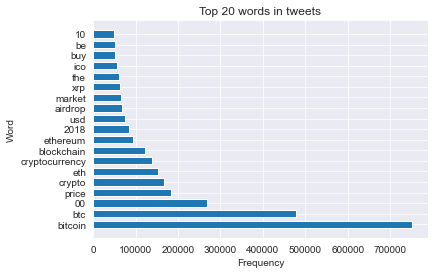

In [16]:
plt.barh(y=top20_text['Word'],width=top20_text['Count'], height = 0.7)
plt.title("Top 20 words in tweets")
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.savefig('graphs_new/Top 20 words in tweets.png', bbox_inches='tight')
plt.show()

In [17]:
final_list = []
for word in top20_text["Word"]:
    final_list.append(word)

In [18]:
pickle_out = open('data/final_list_top20_words.pkl','wb')
pickle.dump(final_list, pickle_out)
pickle_out.close()

# Text Representation using FastText

In [19]:
# Create corpus vectors from the top 5000 words in the comments and posts
corpus_text = tweet_corpus['text_prep_lim']

In [20]:
final_size = 60
window_size = 10
min_word = 3
corpus_text

0                                          [do, not, tether]
1          [the, first, make, diamond, happen, 55, amp, m...
2                           [great, talk, discussion, thank]
3          [when, thing, remember, be, never, bad, crash,...
4          [wow, we, reach, follower, within, week, we, h...
                                 ...                        
1248320                                         [investment]
1248321    [why, not, invest, future, option, do, want, m...
1248322    [think, share, wave, count, least, happen, see...
1248323    [welcome, here, be, who, trust, nobody, when, ...
1248324    [really, come, actual, reddit, thread, be, sta...
Name: text_prep_lim, Length: 923591, dtype: object

In [21]:
# Create the fast text models for both vectors

model_text = FastText(vector_size=final_size,
                       window=window_size,
                       min_count=min_word,
                       seed=1,
                       workers=1)
model_text.build_vocab(corpus_iterable = corpus_text)
model_text.train(corpus_iterable=corpus_text, total_examples=len(corpus_text), epochs=50)

(284222915, 338919450)

In [22]:
# 60-dimensional vector for the word "bitcoin"
model_text.wv['bitcoin']

array([ 0.55954766, -0.33152887, -0.05015212,  0.42202327,  3.0054505 ,
       -0.30021766,  1.1858524 ,  1.2549347 , -1.8303854 , -1.1006662 ,
        1.2730591 ,  2.2634575 ,  0.53116876,  1.465855  ,  0.6455566 ,
       -0.2617931 , -1.7807481 , -1.0450907 , -0.37428933, -1.4007777 ,
       -1.2676094 , -0.65895677,  0.4411267 ,  2.802386  , -0.6195776 ,
        0.02172002, -1.1802076 , -1.3507206 , -0.6215073 , -0.30354577,
        1.7121426 , -0.6427753 , -1.2516326 , -0.3918078 ,  0.15413761,
       -1.0625827 ,  2.247343  , -0.45377395, -0.76737046,  0.41727585,
       -0.54511356, -1.679683  , -1.3911434 , -0.2563572 , -0.7544524 ,
        0.33037418, -4.801147  ,  1.7572577 , -0.2727683 , -1.306693  ,
        0.7474401 , -0.5573917 , -0.32892236, -2.7942693 ,  0.77416867,
        0.6945329 , -3.5890486 ,  0.6643354 ,  0.20817193,  1.364321  ],
      dtype=float32)

In [23]:
model_text.wv.most_similar('bitcoin', topn=5)

[('cryptocurrencynews', 0.7383449673652649),
 ('cryptocurrency', 0.7363299131393433),
 ('bitcoinc', 0.7175474166870117),
 ('cryptocurrencynew', 0.7112036347389221),
 ('cryptonews', 0.7039129734039307)]

In [30]:
model_text.wv.similarity(w1='bitcoin', w2='bitcoinc')

0.71754736

In [25]:
pickle_out = open('data/fast_text_model_text.pkl','wb')
pickle.dump(model_text, pickle_out)
pickle_out.close()

In [26]:
# Load english tweets
pickle_in = open('data/fast_text_model_text.pkl','rb')
model_text = pickle.load(pickle_in)
pickle_in.close()

In [27]:
# Visualize the model
X_text = model_text.wv[final_list]
X_text #an array with all 60-D vectors for all the words in final_list

array([[ 0.55954766, -0.33152887, -0.05015212, ...,  0.6643354 ,
         0.20817193,  1.364321  ],
       [ 2.7730463 , -6.196114  , -0.68836945, ...,  2.9540737 ,
         3.5604026 ,  1.44372   ],
       [ 5.897311  , -4.1775084 , 13.027904  , ..., -4.6884527 ,
         5.9221992 , -5.171298  ],
       ...,
       [-4.2757163 , -3.0265772 , -3.1524773 , ..., -3.2147717 ,
        -4.1940546 ,  5.5254517 ],
       [-5.5158606 , -3.1394143 , -2.3507183 , ...,  2.7914863 ,
        -2.68742   , -0.3410256 ],
       [ 8.3562355 ,  9.358885  , 11.758064  , ...,  1.8793273 ,
        -6.537927  ,  5.8435435 ]], dtype=float32)

# Principal component analysis (PCA)

In [28]:
# To plot sth nice let's reduce the 60 dimensions to 2
pca_text = PCA(n_components=2).fit_transform(X_text)
pca_text

array([[ -1.6854054 ,   1.0153822 ],
       [  6.045469  ,  -4.8889294 ],
       [-15.358817  ,   1.952988  ],
       [ -6.9979844 ,   1.6212807 ],
       [  2.8955991 ,  -3.0839634 ],
       [  7.495666  , -14.626481  ],
       [  0.43024698,  -2.4003518 ],
       [ -1.3809501 ,  -2.942705  ],
       [  4.367801  ,  -3.5379179 ],
       [ -8.257377  ,  -3.7695959 ],
       [ -5.2742233 ,  -6.203668  ],
       [  4.361761  ,  -2.7085412 ],
       [ -5.7922244 ,   3.8146627 ],
       [ 61.183544  ,  23.481815  ],
       [-15.925263  ,   6.555495  ],
       [ 13.184304  , -32.83513   ],
       [-10.364142  ,  10.553118  ],
       [-19.687365  ,  34.230827  ],
       [ -9.240626  ,  -6.2282953 ]], dtype=float32)

In [29]:
fig = px.scatter(x = pca_text[:,0], y = pca_text[:,1], text = final_list)
fig.update_traces(textposition='top center', textfont_size=14)
# plt.savefig('graphs_new/Top 20 words in tweets.png', bbox_inches='tight')
fig.show()

# Sentiment analysis using Vader Lexicon

In [31]:
# Load english tweets
pickle_in = open('data/tweet_corpus_cleaned.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [32]:
# tweet_corpus = pd.read_csv('data/tweet_corpus_cleaned.csv')

In [33]:
tweet_corpus.head()

timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  
0                                  [do, not, tether]                  3  
1  [the, first, make, diamond, happen, 55, amp, m...                 26  
2                   [great, talk, discussion, thank]                  4  
3  [when, thing, remember, be, never, bad, crash,...                 17  
4  [wow, we, reach, follower, within, week, we, h...                 21

In [34]:
tweet_corpus['vader_score'] = tweet_corpus['text_prep'].progress_apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

100%|██████████| 923591/923591 [1:05:56<00:00, 233.47it/s]


In [35]:
text_vader_score = tweet_corpus['text'].progress_apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

100%|██████████| 923591/923591 [1:00:46<00:00, 253.29it/s]


In [36]:
text_prep_vader_score = tweet_corpus['vader_score']

In [37]:
backup = tweet_corpus

In [38]:
tweet_corpus = tweet_corpus.rename(columns={'vader_score': 'vader_score_prep'})

In [39]:
tweet_corpus['vader_score'] = text_vader_score

In [40]:
tweet_corpus.head()

timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  \
0                                  [do, not, tether]                  3   
1  [the, first, make, diamond, happen, 55, amp, m...                 26   
2                   [great, talk, discussion, thank]                  4   
3  [when, thing, remember, be, never, bad, crash,...                 17   
4  [wow, we, reach, follower, within, week, we, h...                 21   

   vader_score_prep  vader_score  
0            0.0000       0.0000  
1            0.7964       0.7678  
2            0.8011       0.8011  
3            0.6259       0.0387  
4            0.9333       0.9368

In [41]:
tweet_corpus.describe()

replies          likes       retweets       text_len  \
count  923591.000000  923591.000000  923591.000000  923591.000000   
mean        0.813219       5.980879       2.416235      25.287963   
std        35.901052     357.416751     101.971908      15.692508   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000      14.000000   
50%         0.000000       0.000000       0.000000      21.000000   
75%         0.000000       1.000000       0.000000      35.000000   
max     22759.000000  282959.000000   64013.000000     179.000000   

       word_len_text_lim  vader_score_prep    vader_score  
count      923591.000000     923591.000000  923591.000000  
mean            7.339167          0.115474       0.108843  
std             5.515406          0.342163       0.335850  
min             0.000000         -0.997000      -0.994800  
25%             3.000000          0.000000       0.000000  
50%             6.000000          0.000000       0.000000  
75%            10.000000          0.340000       0.296000  
max            46.000000          0.991900       0.992800

In [42]:
vader_class = []
for score in tweet_corpus['vader_score']:
    if 1 > score > 0.05:
        vader_class.append('positive')
    elif -0.05 > score > -1:
        vader_class.append('negative')
    else:
        vader_class.append('neutral')

# vader_class

In [43]:
tweet_corpus['vader_class'] = vader_class

In [44]:
vader_class_prep = []
for score in tweet_corpus['vader_score_prep']:
    if 1 > score > 0.05:
        vader_class_prep.append('positive')
    elif -0.05 > score > -1:
        vader_class_prep.append('negative')
    else:
        vader_class_prep.append('neutral')

# vader_class_prep

In [45]:
tweet_corpus['vader_class_prep'] = vader_class_prep

In [46]:
tweet_corpus.head()

timestamp  replies  likes  retweets  \
0  2018-09-11      0.0    3.0       2.0   
1  2018-12-29      9.0   61.0      16.0   
2  2018-04-17      1.0    7.0       1.0   
3  2018-02-08     23.0  135.0      51.0   
4  2018-06-09     39.0  324.0     160.0   

                                                text language  text_len  \
0                   I didnt tether at #iamspartacus        en         6   
1  The first lab made diamond happened in 55 &amp...       en        59   
2  Great talk and discussions about Bitcoin vs. E...       en        15   
3  When things are down, remember it's never as b...       en        62   
4  Wow! We reached K followers just within 4 week...       en        48   

                                           text_prep  \
0                     I do not tether # iamspartacus   
1  the first lab make diamond happen 55 & amp ; f...   
2  great talk discussion Bitcoin vs. Euro Innsbru...   
3  when thing , remember be never bad chocolate c...   
4  wow ! we reach K follower within 4 week Twitte...   

                                       text_prep_lim  word_len_text_lim  \
0                                  [do, not, tether]                  3   
1  [the, first, make, diamond, happen, 55, amp, m...                 26   
2                   [great, talk, discussion, thank]                  4   
3  [when, thing, remember, be, never, bad, crash,...                 17   
4  [wow, we, reach, follower, within, week, we, h...                 21   

   vader_score_prep  vader_score vader_class vader_class_prep  
0            0.0000       0.0000     neutral          neutral  
1            0.7964       0.7678    positive         positive  
2            0.8011       0.8011    positive         positive  
3            0.6259       0.0387     neutral         positive  
4            0.9333       0.9368    positive         positive

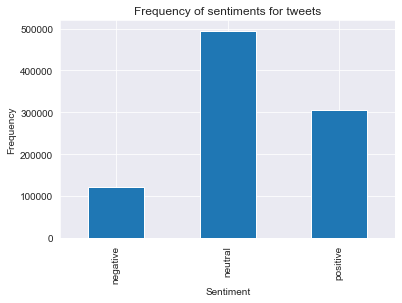

In [47]:
fig = tweet_corpus['vader_class'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of sentiments for tweets')
fig.set_xlabel('Sentiment')
fig.set_ylabel('Frequency')
plt.savefig('graphs_new/Frequency of sentiments for tweets.png', bbox_inches='tight')
plt.show()

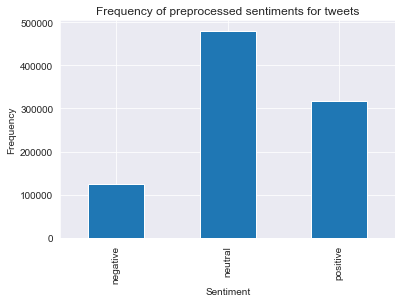

In [48]:
fig = tweet_corpus['vader_class_prep'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of preprocessed sentiments for tweets')
fig.set_xlabel('Sentiment')
fig.set_ylabel('Frequency')
plt.savefig('graphs_new/Frequency of preprocessed sentiments for tweets.png', bbox_inches='tight')
plt.show()

In [49]:
pickle_out = open('data/tweets_vader.pkl', 'wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

In [50]:
tweet_corpus.to_csv("data/tweets_vader.csv", index=False)

# Read bitcoin price dataset

In [64]:
bitcoin_price = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [65]:
len(bitcoin_price)

4857377

In [66]:
bitcoin_price.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [67]:
bitcoin_price = bitcoin_price.fillna(bitcoin_price.mean())

In [68]:
bitcoin_price.head()

Timestamp        Open         High          Low        Close  \
0  1325317920     4.39000     4.390000     4.390000     4.390000   
1  1325317980  6009.02368  6013.357082  6004.488004  6009.013545   
2  1325318040  6009.02368  6013.357082  6004.488004  6009.013545   
3  1325318100  6009.02368  6013.357082  6004.488004  6009.013545   
4  1325318160  6009.02368  6013.357082  6004.488004  6009.013545   

   Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0      0.455581           2.000000          4.3900  
1      9.323249       41762.842397       6008.9348  
2      9.323249       41762.842397       6008.9348  
3      9.323249       41762.842397       6008.9348  
4      9.323249       41762.842397       6008.9348

In [69]:
def ttd(x):
    return datetime.datetime.utcfromtimestamp(x)

In [70]:
bitcoin_price['Timestamp'] = bitcoin_price['Timestamp'].progress_apply(ttd)

100%|██████████| 4857377/4857377 [00:03<00:00, 1394054.38it/s]


In [71]:
bitcoin_price.head()

Timestamp        Open         High          Low        Close  \
0 2011-12-31 07:52:00     4.39000     4.390000     4.390000     4.390000   
1 2011-12-31 07:53:00  6009.02368  6013.357082  6004.488004  6009.013545   
2 2011-12-31 07:54:00  6009.02368  6013.357082  6004.488004  6009.013545   
3 2011-12-31 07:55:00  6009.02368  6013.357082  6004.488004  6009.013545   
4 2011-12-31 07:56:00  6009.02368  6013.357082  6004.488004  6009.013545   

   Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0      0.455581           2.000000          4.3900  
1      9.323249       41762.842397       6008.9348  
2      9.323249       41762.842397       6008.9348  
3      9.323249       41762.842397       6008.9348  
4      9.323249       41762.842397       6008.9348

In [72]:
bitcoin_price.isna().any()

Timestamp            False
Open                 False
High                 False
Low                  False
Close                False
Volume_(BTC)         False
Volume_(Currency)    False
Weighted_Price       False
dtype: bool

In [73]:
min(bitcoin_price['Timestamp'])

Timestamp('2011-12-31 07:52:00')

In [74]:
max(bitcoin_price['Timestamp'])

Timestamp('2021-03-31 00:00:00')

In [75]:
bitcoin_price['date'] = bitcoin_price['Timestamp'].progress_apply(dt)

100%|██████████| 4857377/4857377 [00:09<00:00, 501350.69it/s] 


In [76]:
bitcoin_price.head()

Timestamp        Open         High          Low        Close  \
0 2011-12-31 07:52:00     4.39000     4.390000     4.390000     4.390000   
1 2011-12-31 07:53:00  6009.02368  6013.357082  6004.488004  6009.013545   
2 2011-12-31 07:54:00  6009.02368  6013.357082  6004.488004  6009.013545   
3 2011-12-31 07:55:00  6009.02368  6013.357082  6004.488004  6009.013545   
4 2011-12-31 07:56:00  6009.02368  6013.357082  6004.488004  6009.013545   

   Volume_(BTC)  Volume_(Currency)  Weighted_Price        date  
0      0.455581           2.000000          4.3900  2011-12-31  
1      9.323249       41762.842397       6008.9348  2011-12-31  
2      9.323249       41762.842397       6008.9348  2011-12-31  
3      9.323249       41762.842397       6008.9348  2011-12-31  
4      9.323249       41762.842397       6008.9348  2011-12-31

In [77]:
starDate = datetime.date(2018, 1, 1)
endDate = datetime.date(2018, 12, 31)

In [78]:
bitcoin_price = bitcoin_price[bitcoin_price['date'] >= starDate]

In [79]:
bitcoin_price = bitcoin_price[bitcoin_price['date'] <= endDate]

In [80]:
bitcoin_price

Timestamp      Open      High       Low     Close  \
3150976 2018-01-01 00:00:00  13880.00  13906.37  13841.00  13841.01   
3150977 2018-01-01 00:01:00  13841.01  13890.43  13841.01  13890.43   
3150978 2018-01-01 00:02:00  13846.64  13890.35  13846.64  13847.51   
3150979 2018-01-01 00:03:00  13847.51  13874.92  13823.19  13823.19   
3150980 2018-01-01 00:04:00  13823.19  13826.75  13803.20  13803.20   
...                     ...       ...       ...       ...       ...   
3676571 2018-12-31 23:55:00   3688.28   3688.85   3685.00   3688.85   
3676572 2018-12-31 23:56:00   3687.87   3689.65   3686.92   3686.92   
3676573 2018-12-31 23:57:00   3688.83   3689.26   3688.83   3689.26   
3676574 2018-12-31 23:58:00   3689.26   3691.35   3689.26   3691.35   
3676575 2018-12-31 23:59:00   3689.26   3693.30   3689.26   3693.30   

         Volume_(BTC)  Volume_(Currency)  Weighted_Price        date  
3150976      4.967997       69030.718890    13895.081610  2018-01-01  
3150977      1.665850       23064.082359    13845.237237  2018-01-01  
3150978      0.269346        3739.690844    13884.349123  2018-01-01  
3150979      1.155274       15986.279494    13837.650132  2018-01-01  
3150980      0.646691        8930.465767    13809.482390  2018-01-01  
...               ...                ...             ...         ...  
3676571      7.665703       28263.698185     3687.032614  2018-12-31  
3676572      7.610240       28063.290959     3687.569750  2018-12-31  
3676573      0.560833        2068.943311     3689.052647  2018-12-31  
3676574      0.560000        2066.110758     3689.483496  2018-12-31  
3676575      9.838855       36311.346546     3690.607113  2018-12-31  

[525600 rows x 9 columns]

In [81]:
len(bitcoin_price)

525600

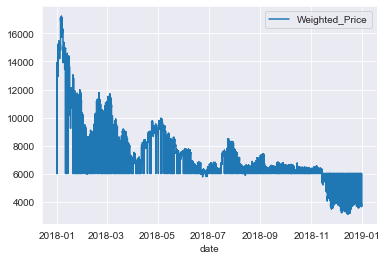

In [82]:
bitcoin_price.plot(x='date', y='Weighted_Price', kind="line")
plt.savefig('graphs_new/bitcoin before avg.png', bbox_inches='tight')
plt.show()

In [83]:
bitcoin_price_avg = bitcoin_price.groupby('date').mean()

In [84]:
bitcoin_price_avg = bitcoin_price_avg.reset_index()

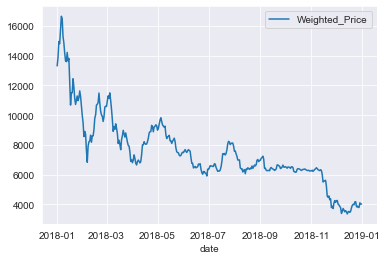

In [85]:
bitcoin_price_avg.plot(x='date', y='Weighted_Price', kind="line")
plt.savefig('graphs_new/bitcoin after avg.png', bbox_inches='tight')
plt.show()

In [86]:
bitcoin_price.dtypes

Timestamp            datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
date                         object
dtype: object

In [87]:
bitcoin_price['date'] = pd.to_datetime(bitcoin_price['date'])

In [88]:
bitcoin_price_avg.dtypes

date                  object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [89]:
bitcoin_price_avg['date'] = pd.to_datetime(bitcoin_price_avg['date'])

In [90]:
tweet_corpus = pd.read_csv("data/tweets_vader.csv")

In [91]:
tweet_corpus.dtypes

timestamp             object
replies              float64
likes                float64
retweets             float64
text                  object
language              object
text_len               int64
text_prep             object
text_prep_lim         object
word_len_text_lim      int64
vader_score_prep     float64
vader_score          float64
vader_class           object
vader_class_prep      object
dtype: object

In [92]:
tweet_corpus['date'] = pd.to_datetime(tweet_corpus['timestamp'])

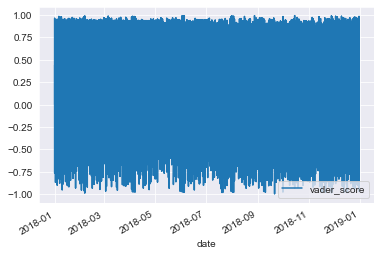

In [93]:
tweet_corpus.plot(x='date', y='vader_score', kind="line")
plt.savefig('graphs_new/vader_score before avg.png', bbox_inches='tight')
plt.show()

In [94]:
len(tweet_corpus)

923591

In [95]:
tweet_corpus_avg = tweet_corpus.groupby('date').mean()

In [96]:
tweet_corpus_avg = tweet_corpus_avg.reset_index()

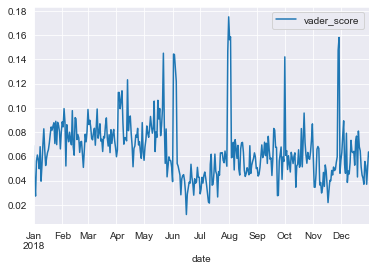

In [97]:
tweet_corpus_avg.plot(x='date', y='vader_score', kind="line")
plt.savefig('graphs_new/vader_score after avg.png', bbox_inches='tight')
plt.show()

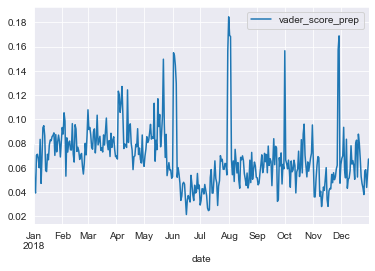

In [98]:
tweet_corpus_avg.plot(x='date', y='vader_score_prep', kind="line")
plt.savefig('graphs_new/vader_score_prep after avg.png', bbox_inches='tight')
plt.show()

In [99]:
len(tweet_corpus)

923591

In [100]:
len(tweet_corpus_avg)

365

In [101]:
len(bitcoin_price)

525600

In [102]:
len(bitcoin_price_avg)

365

In [103]:
tweet_corpus.to_csv("data/tweets_corpus_vader.csv", index=False)

In [104]:
tweet_corpus_avg.to_csv("data/tweets_corpus_vader_avg.csv", index=False)

In [105]:
bitcoin_price.to_csv("data/bitcoin_price.csv", index=False)

In [106]:
bitcoin_price_avg.to_csv("data/bitcoin_price_avg.csv", index=False)

# Merge the dataframes

In [107]:
# tweet_corpus = pd.read_csv('data/tweets_corpus_vader.csv')
tweet_corpus_avg = pd.read_csv('data/tweets_corpus_vader_avg.csv')
# bitcoin_price = pd.read_csv('data/bitcoin_price.csv')
bitcoin_price_avg = pd.read_csv('data/bitcoin_price_avg.csv')

In [108]:
twitter_vaderAVG_priceAVG = pd.merge(tweet_corpus_avg, bitcoin_price_avg, on='date')

In [109]:
twitter_vaderAVG_priceAVG.to_csv('data/twitter_vaderAVG_priceAVG.csv', index=False)

In [110]:
twitter_vaderAVG_priceAVG = pd.read_csv('data/twitter_vaderAVG_priceAVG.csv')

In [111]:
len(twitter_vaderAVG_priceAVG)

365

In [112]:
twitter_vaderAVG_priceAVG.head()

date   replies      likes   retweets   text_len  word_len_text_lim  \
0  2018-01-01  0.252503   1.743048   1.363737  26.630701           5.139043   
1  2018-01-02  0.877381   8.283333  10.578571  27.805952           5.654762   
2  2018-01-03  0.592822  11.955446   7.022277  27.513614           5.247525   
3  2018-01-04  0.729529   7.538462   3.107940  27.449132           5.447891   
4  2018-01-05  1.618026   7.723176   4.600858  26.328326           5.292918   

   vader_score_prep  vader_score          Open          High           Low  \
0          0.078898     0.068968  13321.554065  13340.457529  13299.922007   
1          0.042676     0.039405  13876.355194  13898.509590  13855.027465   
2          0.039350     0.027376  14962.191285  14984.432583  14939.789938   
3          0.070379     0.056172  14816.667590  14839.287014  14793.340396   
4          0.071265     0.061227  15790.230722  15811.529299  15768.255285   

          Close  Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0  13321.012751      5.468400       71979.843958    13319.599896  
1  13879.358896     11.319215      159124.197276    13877.579911  
2  14963.699340      8.524306      127527.370651    14962.379078  
3  14818.780319     10.419457      154277.947563    14816.625468  
4  15792.452507     11.283969      180344.370037    15790.446145

In [113]:
twitter_vaderAVG_priceAVG = twitter_vaderAVG_priceAVG.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'replies', 'likes', 'retweets', 'text_len', 'word_len_text_lim'])

In [114]:
twitter_vaderAVG_priceAVG

date  vader_score_prep  vader_score  Weighted_Price
0    2018-01-01          0.078898     0.068968    13319.599896
1    2018-01-02          0.042676     0.039405    13877.579911
2    2018-01-03          0.039350     0.027376    14962.379078
3    2018-01-04          0.070379     0.056172    14816.625468
4    2018-01-05          0.071265     0.061227    15790.446145
..          ...               ...          ...             ...
360  2018-12-27          0.057652     0.055907     3782.760635
361  2018-12-28          0.058564     0.052159     3783.455903
362  2018-12-29          0.043943     0.037092     4095.580711
363  2018-12-30          0.055197     0.049873     4019.246347
364  2018-12-31          0.067352     0.063773     4011.559939

[365 rows x 4 columns]

In [115]:
twitter_vaderAVG_priceAVG.dtypes

date                 object
vader_score_prep    float64
vader_score         float64
Weighted_Price      float64
dtype: object

In [116]:
twitter_vaderAVG_priceAVG['date'] = pd.to_datetime(twitter_vaderAVG_priceAVG['date'])

In [117]:
# twitter_vaderAVG_priceAVG['fluctuation (%)'] = twitter_vaderAVG_priceAVG['Weighted_Price'].pct_change()*100

In [118]:
twitter_vaderAVG_priceAVG

date  vader_score_prep  vader_score  Weighted_Price
0   2018-01-01          0.078898     0.068968    13319.599896
1   2018-01-02          0.042676     0.039405    13877.579911
2   2018-01-03          0.039350     0.027376    14962.379078
3   2018-01-04          0.070379     0.056172    14816.625468
4   2018-01-05          0.071265     0.061227    15790.446145
..         ...               ...          ...             ...
360 2018-12-27          0.057652     0.055907     3782.760635
361 2018-12-28          0.058564     0.052159     3783.455903
362 2018-12-29          0.043943     0.037092     4095.580711
363 2018-12-30          0.055197     0.049873     4019.246347
364 2018-12-31          0.067352     0.063773     4011.559939

[365 rows x 4 columns]

In [119]:
twitter_vaderAVG_priceAVG.corr()

vader_score_prep  vader_score  Weighted_Price
vader_score_prep          1.000000     0.983487        0.236216
vader_score               0.983487     1.000000        0.211869
Weighted_Price            0.236216     0.211869        1.000000

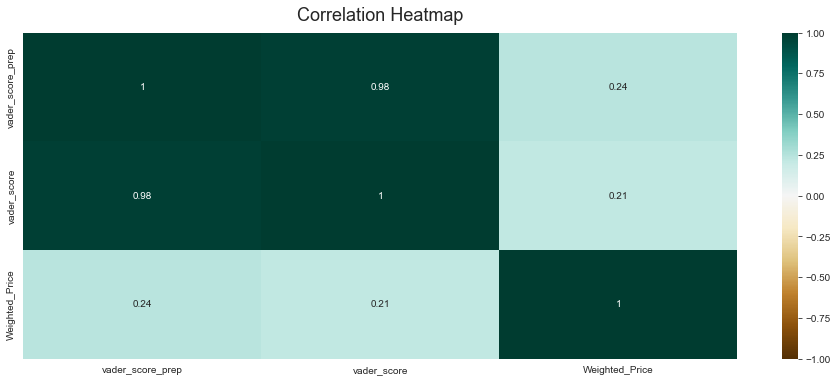

In [120]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(twitter_vaderAVG_priceAVG.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('graphs_new/Correlation Heatmap.png', bbox_inches='tight')

In [121]:
lagged_correlation = pd.DataFrame.from_dict(
    {x: [twitter_vaderAVG_priceAVG['vader_score'].corr(twitter_vaderAVG_priceAVG['Weighted_Price'].shift(-t)) for t in range(10)] for x in twitter_vaderAVG_priceAVG.columns})

In [122]:
lagged_correlation

date  vader_score_prep  vader_score  Weighted_Price
0  0.211869          0.211869     0.211869        0.211869
1  0.212315          0.212315     0.212315        0.212315
2  0.203199          0.203199     0.203199        0.203199
3  0.193197          0.193197     0.193197        0.193197
4  0.185642          0.185642     0.185642        0.185642
5  0.183759          0.183759     0.183759        0.183759
6  0.178821          0.178821     0.178821        0.178821
7  0.175997          0.175997     0.175997        0.175997
8  0.168480          0.168480     0.168480        0.168480
9  0.165320          0.165320     0.165320        0.165320

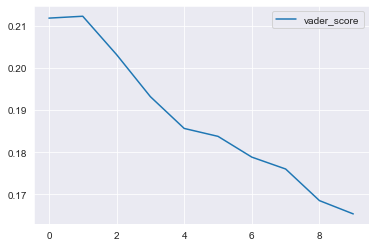

In [123]:
lagged_correlation.plot(y='vader_score', kind="line", use_index=True)
plt.savefig('graphs_new/lagged_correlation vader_score.png', bbox_inches='tight')
plt.show()

In [124]:
lagged_correlation_prep = pd.DataFrame.from_dict(
    {x: [twitter_vaderAVG_priceAVG['vader_score_prep'].corr(twitter_vaderAVG_priceAVG['Weighted_Price'].shift(-t)) for t in range(10)] for x in twitter_vaderAVG_priceAVG.columns})

In [125]:
lagged_correlation_prep

date  vader_score_prep  vader_score  Weighted_Price
0  0.236216          0.236216     0.236216        0.236216
1  0.235406          0.235406     0.235406        0.235406
2  0.228505          0.228505     0.228505        0.228505
3  0.218638          0.218638     0.218638        0.218638
4  0.210146          0.210146     0.210146        0.210146
5  0.206216          0.206216     0.206216        0.206216
6  0.198766          0.198766     0.198766        0.198766
7  0.195104          0.195104     0.195104        0.195104
8  0.185998          0.185998     0.185998        0.185998
9  0.182894          0.182894     0.182894        0.182894

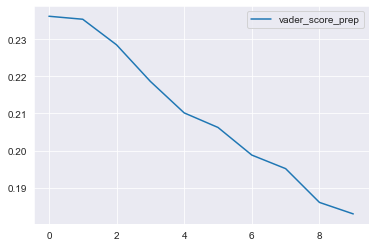

In [126]:
lagged_correlation_prep.plot(y='vader_score_prep', kind="line", use_index=True)
plt.savefig('graphs_new/lagged_correlation vader_score_prep.png', bbox_inches='tight')
plt.show()

# Normalizing data

In [127]:
twitter_vaderAVG_priceAVG

date  vader_score_prep  vader_score  Weighted_Price
0   2018-01-01          0.078898     0.068968    13319.599896
1   2018-01-02          0.042676     0.039405    13877.579911
2   2018-01-03          0.039350     0.027376    14962.379078
3   2018-01-04          0.070379     0.056172    14816.625468
4   2018-01-05          0.071265     0.061227    15790.446145
..         ...               ...          ...             ...
360 2018-12-27          0.057652     0.055907     3782.760635
361 2018-12-28          0.058564     0.052159     3783.455903
362 2018-12-29          0.043943     0.037092     4095.580711
363 2018-12-30          0.055197     0.049873     4019.246347
364 2018-12-31          0.067352     0.063773     4011.559939

[365 rows x 4 columns]

In [128]:
vader_score_prep_backup = twitter_vaderAVG_priceAVG['vader_score_prep']
vader_score_backup = twitter_vaderAVG_priceAVG['vader_score']
# fluctuation_backup = twitter_vaderAVG_priceAVG['fluctuation (%)']

In [129]:
twitter_vaderAVG_priceAVG.set_index('date', inplace=True)

In [130]:
x = twitter_vaderAVG_priceAVG.values

In [131]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [132]:
twitter_vaderAVG_priceAVG.head()

vader_score_prep  vader_score  Weighted_Price
date                                                     
2018-01-01          0.078898     0.068968    13319.599896
2018-01-02          0.042676     0.039405    13877.579911
2018-01-03          0.039350     0.027376    14962.379078
2018-01-04          0.070379     0.056172    14816.625468
2018-01-05          0.071265     0.061227    15790.446145

In [133]:
twitter_vaderAVG_priceAVG_norm = pd.DataFrame(x_scaled, index=twitter_vaderAVG_priceAVG.index,
                                              columns=[
                                                  'vader_score_prep_norm',
                                                  'vader_score_norm',
                                                  'Weighted_Price_norm'
                                              ])
twitter_vaderAVG_priceAVG_norm

vader_score_prep_norm  vader_score_norm  Weighted_Price_norm
date                                                                    
2018-01-01               0.351655          0.348544             0.748799
2018-01-02               0.129274          0.167135             0.790694
2018-01-03               0.108855          0.093316             0.872143
2018-01-04               0.299352          0.270019             0.861199
2018-01-05               0.304793          0.301042             0.934316
...                           ...               ...                  ...
2018-12-27               0.221214          0.268394             0.032750
2018-12-28               0.226813          0.245397             0.032802
2018-12-29               0.137049          0.152938             0.056237
2018-12-30               0.206146          0.231371             0.050506
2018-12-31               0.280766          0.316663             0.049929

[365 rows x 3 columns]

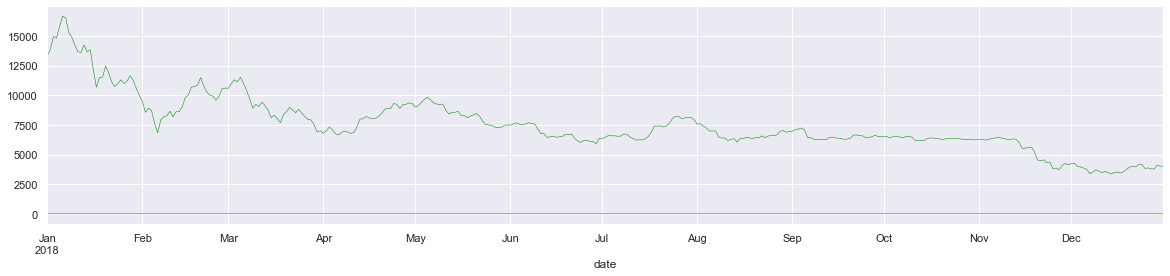

In [134]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG['Weighted_Price'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG['vader_score_prep'].plot(linewidth=0.5, color='red');

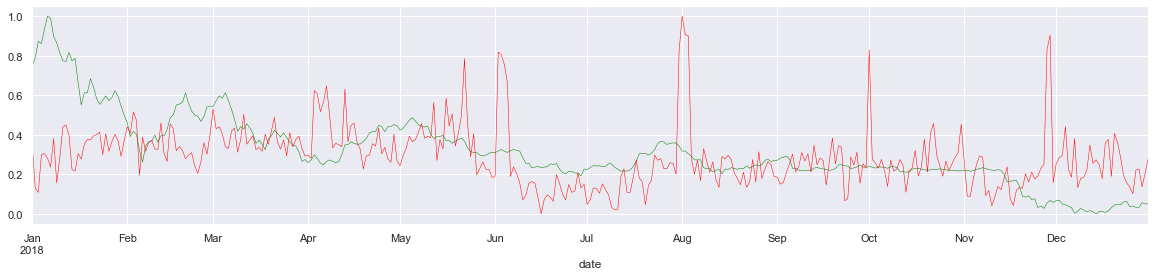

In [135]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG_norm['vader_score_prep_norm'].plot(linewidth=0.5, color='red');

In [136]:
twitter_vaderAVG_priceAVG.to_csv('data/twitter_vaderAVG_priceAVG.csv')
twitter_vaderAVG_priceAVG_norm.to_csv('data/twitter_vaderAVG_priceAVG_norm.csv')

In [137]:
twitter_vaderAVG_priceAVG = pd.read_csv('data/twitter_vaderAVG_priceAVG.csv')
twitter_vaderAVG_priceAVG_norm = pd.read_csv('data/twitter_vaderAVG_priceAVG_norm.csv')

In [138]:
twitter_vaderAVG_priceAVG.head()

date  vader_score_prep  vader_score  Weighted_Price
0  2018-01-01          0.078898     0.068968    13319.599896
1  2018-01-02          0.042676     0.039405    13877.579911
2  2018-01-03          0.039350     0.027376    14962.379078
3  2018-01-04          0.070379     0.056172    14816.625468
4  2018-01-05          0.071265     0.061227    15790.446145

In [139]:
twitter_vaderAVG_priceAVG_norm.head()

date  vader_score_prep_norm  vader_score_norm  Weighted_Price_norm
0  2018-01-01               0.351655          0.348544             0.748799
1  2018-01-02               0.129274          0.167135             0.790694
2  2018-01-03               0.108855          0.093316             0.872143
3  2018-01-04               0.299352          0.270019             0.861199
4  2018-01-05               0.304793          0.301042             0.934316

In [140]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG_norm['vader_score_prep_norm']:
    if 1 > score > 0.05:
        vader_class_prep.append(1)
    elif -0.05 > score > -1:
        vader_class_prep.append(-1)
    else:
        vader_class_prep.append(0)

# vader_class_prep

In [141]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'] = vader_class_prep

In [142]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'].value_counts()

1    356
0      9
Name: vader_class_prep, dtype: int64

In [143]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG['vader_score']:
    if 1 > score > 0.05:
        vader_class_prep.append(1)
    elif -0.05 > score > -1:
        vader_class_prep.append(-1)
    else:
        vader_class_prep.append(0)

# vader_class_prep

In [144]:
twitter_vaderAVG_priceAVG['vader_class'] = vader_class_prep

In [145]:
twitter_vaderAVG_priceAVG['vader_class'].value_counts()

1    271
0     94
Name: vader_class, dtype: int64

In [146]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG['vader_score_prep']:
    if 1 > score > 0.05:
        vader_class_prep.append(1)
    elif -0.05 > score > -1:
        vader_class_prep.append(-1)
    else:
        vader_class_prep.append(0)

# vader_class_prep

In [147]:
twitter_vaderAVG_priceAVG['vader_class_prep'] = vader_class_prep

In [148]:
twitter_vaderAVG_priceAVG['vader_class_prep'].value_counts()

1    291
0     74
Name: vader_class_prep, dtype: int64

# SPREG OLS

In [149]:
y = twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm']
X = twitter_vaderAVG_priceAVG_norm[['vader_score_prep_norm']]

In [150]:
X_spreg = X.to_numpy(dtype=float)
y_spreg = y.to_numpy(dtype=float)

In [151]:
spregOLS = spreg.OLS(y_spreg, X_spreg, nonspat_diag=True, name_y="Weighted_Price_norm", name_x=['vader_score_prep'])
print(spregOLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Weighted_Price_norm                Number of Observations:         365
Mean dependent var  :      0.3132                Number of Variables   :           2
S.D. dependent var  :      0.1793                Degrees of Freedom    :         363
R-squared           :      0.0558
Adjusted R-squared  :      0.0532
Sum squared residual:      11.048                F-statistic           :     21.4516
Sigma-square        :       0.030                Prob(F-statistic)     :   5.064e-06
S.E. of regression  :       0.174                Log likelihood        :     120.407
Sigma-square ML     :       0.030                Akaike info criterion :    -236.813
S.E of regression ML:      0.1740                Schwarz criterion     :    -229.013

----------------------------------------------------------------------

### train test split

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [153]:
twitter_vaderAVG_priceAVG_norm.isna().any()

date                     False
vader_score_prep_norm    False
vader_score_norm         False
Weighted_Price_norm      False
vader_class_prep         False
dtype: bool

In [154]:
# X = twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm'].to_list()
X = twitter_vaderAVG_priceAVG['Weighted_Price'].to_list()
#
# y = twitter_vaderAVG_priceAVG_norm['vader_class_prep'].to_list()
y = twitter_vaderAVG_priceAVG['vader_class_prep'].to_list()


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None, stratify=y)

In [156]:
X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))

#### Logistic Regression

In [157]:
logisticRegression = LogisticRegression().fit(X_train, y_train)
logisticRegression.score(X_test, y_test)

0.8

In [158]:
from collections import Counter

In [159]:
y_pred = logisticRegression.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.80      1.00      0.89        88

    accuracy                           0.80       110
   macro avg       0.40      0.50      0.44       110
weighted avg       0.64      0.80      0.71       110



In [161]:
print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  0.2


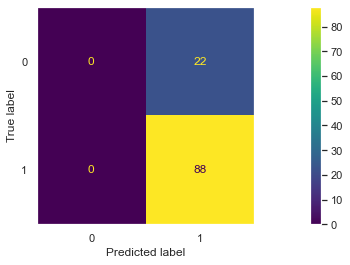

In [162]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logisticRegression.classes_)
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()

#### SVC

In [163]:
svc = svm.SVC(decision_function_shape='ovo')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8

In [164]:
y_pred = svc.predict(X_test)

In [165]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.80      1.00      0.89        88

    accuracy                           0.80       110
   macro avg       0.40      0.50      0.44       110
weighted avg       0.64      0.80      0.71       110



In [166]:
print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  0.2


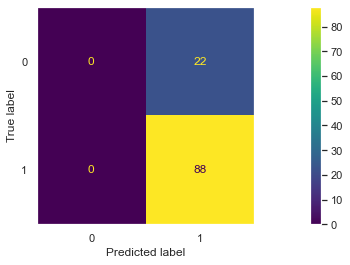

In [167]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()

# Decision Tree Classifier

In [168]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [180]:
# 15 cel mai bun pana acum 0.45/0.86

In [300]:
dtc = DecisionTreeClassifier(max_depth=15)

In [301]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15)

In [302]:
y_pred = dtc.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [303]:
accuracy_score(y_test, y_pred)

0.7818181818181819

In [304]:
target_names = ['positive', 'neutral']
feature_names = ['Weighted_Price_norm']

In [305]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45        22
           1       0.86      0.86      0.86        88

    accuracy                           0.78       110
   macro avg       0.66      0.66      0.66       110
weighted avg       0.78      0.78      0.78       110



In [306]:
print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  0.21818181818181817


In [307]:
plt.figure(figsize = (30, 30), dpi=512)
plot_tree(dtc, feature_names=feature_names, class_names=target_names, filled=True)
plt.savefig('graphs_new/tree.png', bbox_inches='tight')
plt.close()

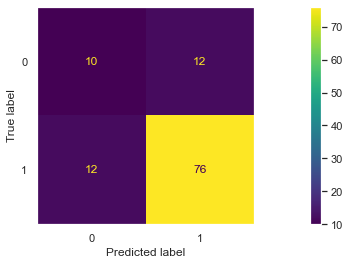

In [308]:
cm  = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()